<h1>Book Contents</h1>
<li>Creation of 2D Integer-to-Integer 5/3 Lifting Wavelet transform</li>
<li>Perform Transform on a file (irrespective of format, <a href=https://ieeexplore.ieee.org/document/8692644>HanQiu[2021]</a> ) at level 2</li>


In [66]:
!pip install pillow
!pip install numpy
!pip install numba
!pip install opencv-python
!pip install pycryptodome
!pip install quantcrypt


In [67]:
from PIL import Image
from IPython.display import display, HTML

def display_images_in_grid(ll, hl, lh, hh):
    
    display(HTML('<h2>LL</h2>'))
    display(Image.fromarray(ll))
    print(ll.shape)
    
    display(HTML('<h2>HL</h2>'))
    display(Image.fromarray(hl))
    print(hl.shape)

    display(HTML('<h2>LH</h2>'))
    display(Image.fromarray(lh))
    print(lh.shape)

    display(HTML('<h2>HH</h2>'))
    display(Image.fromarray(hh))
    print(hh.shape)

<h1>2D DWT Transform.</h1>

In [68]:
import numpy as np
from numba import njit

@njit
def dwt(seq):
    seq = np.copy(seq)
    n = seq.shape[0]

    detail_len = n >> 1
    approx_len = n - detail_len

    for i in range(1, detail_len):
        seq[(i << 1) - 1] -= (seq[(i - 1) << 1] + seq[i << 1]) >> 1
    seq[(detail_len << 1) - 1] -= (seq[(detail_len - 1) << 1] + seq[(approx_len - 1) << 1]) >> 1

    seq[0] += (seq[1] + seq[1] + 2) >> 2
    for i in range(1, approx_len - 1):
        seq[i << 1] += (seq[(i << 1) - 1] + seq[(i << 1) + 1] + 2) >> 2
    seq[(approx_len - 1) << 1] += (seq[(approx_len << 1) - 3] + seq[(detail_len << 1) - 1] + 2) >> 2

    return seq

@njit
def idwt(seq):
    seq = np.copy(seq)
    n = seq.shape[0]

    detail_len = n >> 1
    approx_len = n - detail_len
    
    seq[0] -= (seq[1] + seq[1] + 2) >> 2
    for i in range(1, approx_len - 1):
        seq[i << 1] -= (seq[(i << 1) - 1] + seq[(i << 1) + 1] + 2) >> 2
    seq[(approx_len - 1) << 1] -= (seq[(approx_len << 1) - 3] + seq[(detail_len << 1) - 1] + 2) >> 2

    for i in range(1, detail_len):
        seq[(i << 1) - 1] += (seq[(i - 1) << 1] + seq[i << 1]) >> 1
    seq[(detail_len << 1) - 1] += (seq[(detail_len - 1) << 1] + seq[(approx_len - 1) << 1]) >> 1

    return seq


def dwt2d(seq):
    
    horizontal_transform = np.apply_along_axis(dwt, axis=1, arr=seq)
    l = horizontal_transform[:,::2]
    h = horizontal_transform[:,1::2]
      
    vertical_transform_l = np.apply_along_axis(dwt, axis=0, arr=l)
    ll = np.array(vertical_transform_l[::2,:])
    lh = np.array(vertical_transform_l[1::2,:])
 
    vertical_transform_h = np.apply_along_axis(dwt, axis=0, arr=h)
    hl = np.array(vertical_transform_h[::2,:])    
    hh = np.array(vertical_transform_h[1::2,:])
    
    return ll, hl, lh, hh


def idwt2d(ll, hl, lh, hh):
    
    l_rows = ll.shape[0] + lh.shape[0]
    l_cols = max(ll.shape[1], lh.shape[1])
    vertical_transform_l = np.empty((l_rows, l_cols), dtype=ll.dtype)
    vertical_transform_l[::2, :] = ll
    vertical_transform_l[1::2, :] = lh
    l = np.apply_along_axis(idwt, axis=0, arr=vertical_transform_l)    
    
    h_rows = hl.shape[0] + hh.shape[0]
    h_cols = max(hl.shape[1], hh.shape[1])
    vertical_transform_h = np.empty((h_rows, h_cols), dtype=hl.dtype)
    vertical_transform_h[::2, :] = hl
    vertical_transform_h[1::2, :] = hh
    h = np.apply_along_axis(idwt, axis=0, arr=vertical_transform_h)

    seq_rows = max(l.shape[0], h.shape[0])
    seq_cols = l.shape[1]+h.shape[1]
    horizontal_transform = np.empty((seq_rows, seq_cols), dtype=l.dtype)
    horizontal_transform[:, ::2] = l
    horizontal_transform[:, 1::2] = h
    seq = np.apply_along_axis(idwt, axis=1, arr=horizontal_transform)
    
    return seq
        

<br><h1>2D DWT test with image input.</h1>

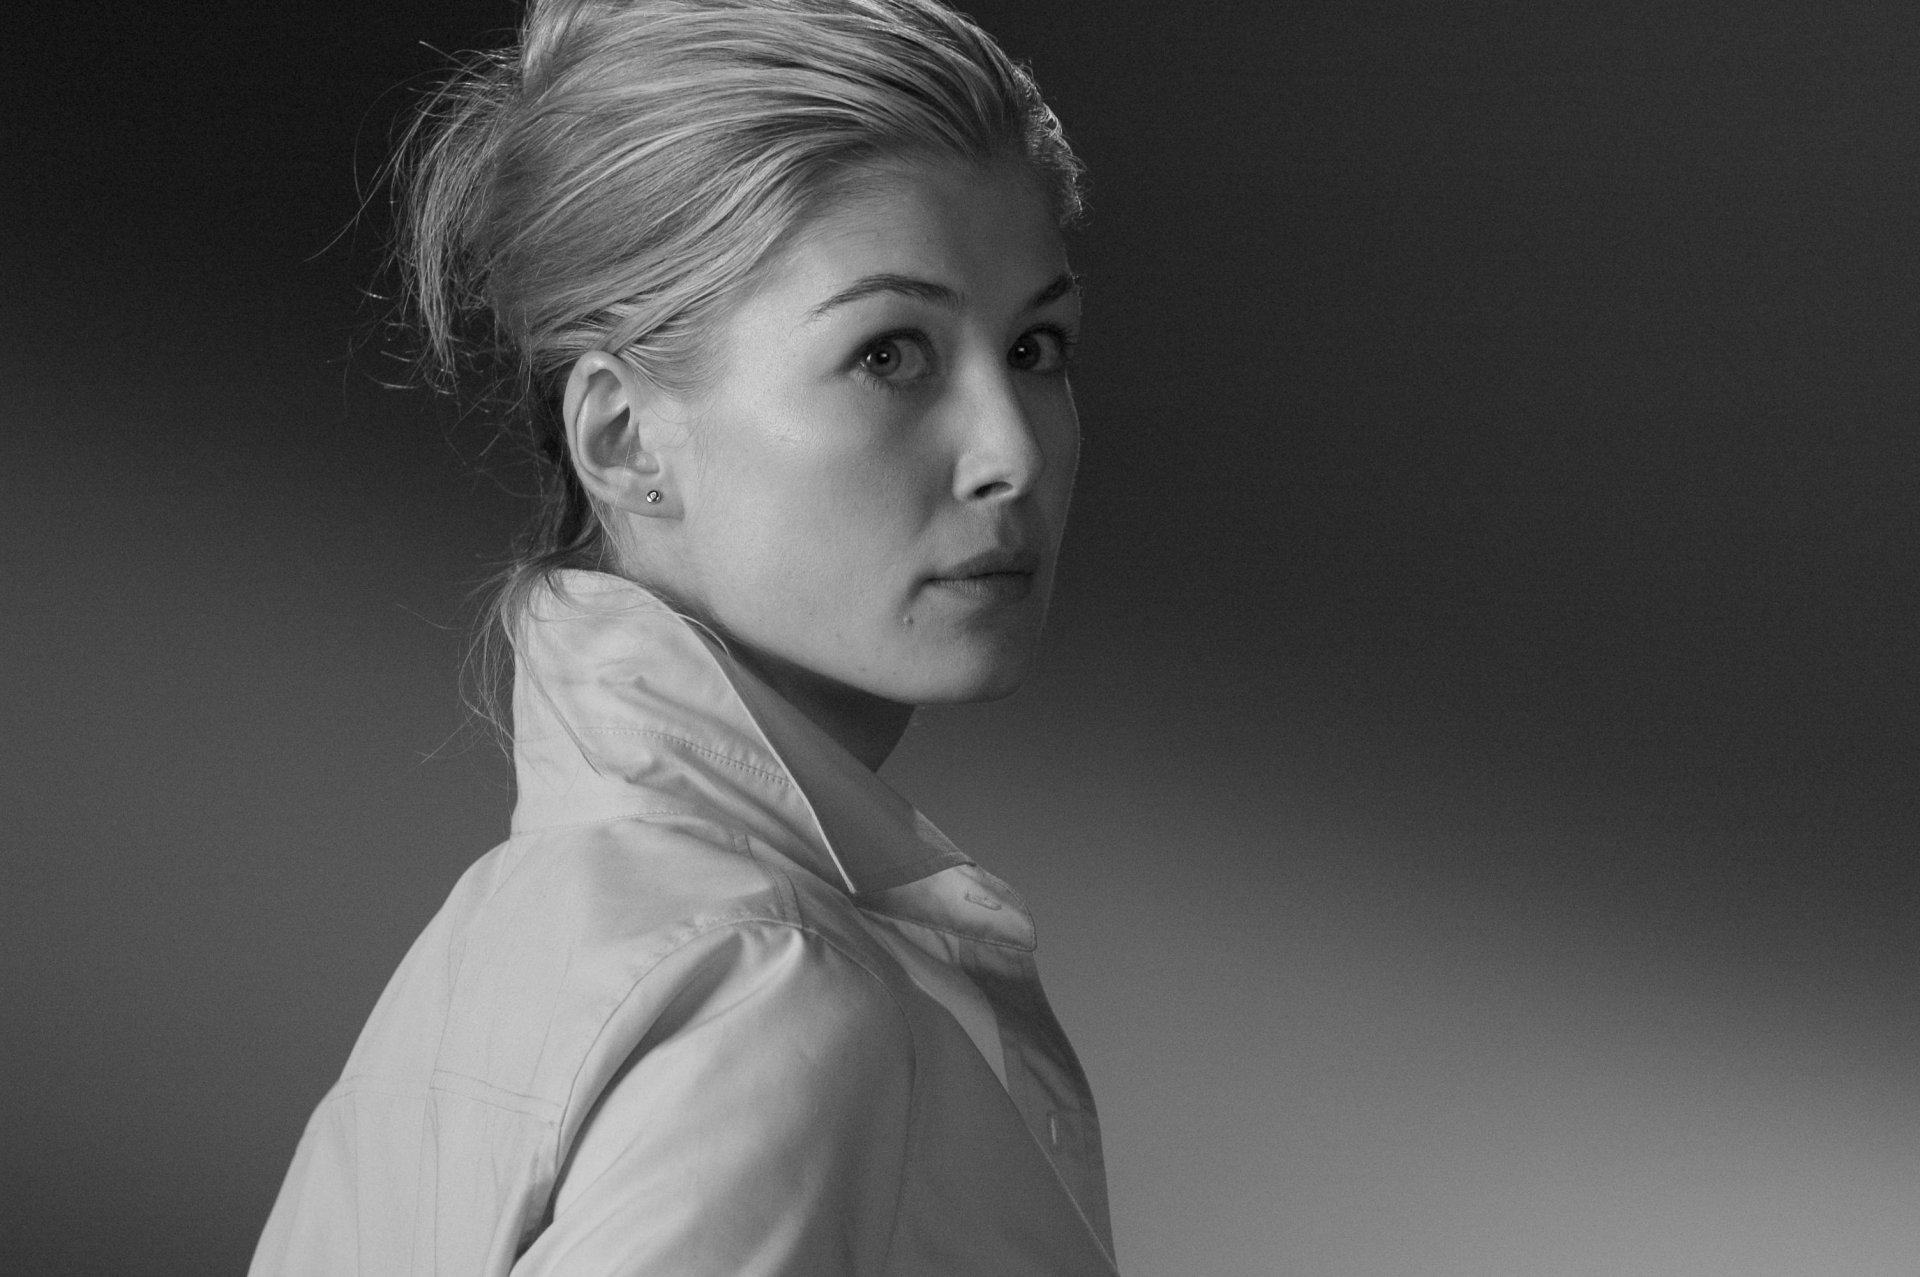

(1277, 1920)


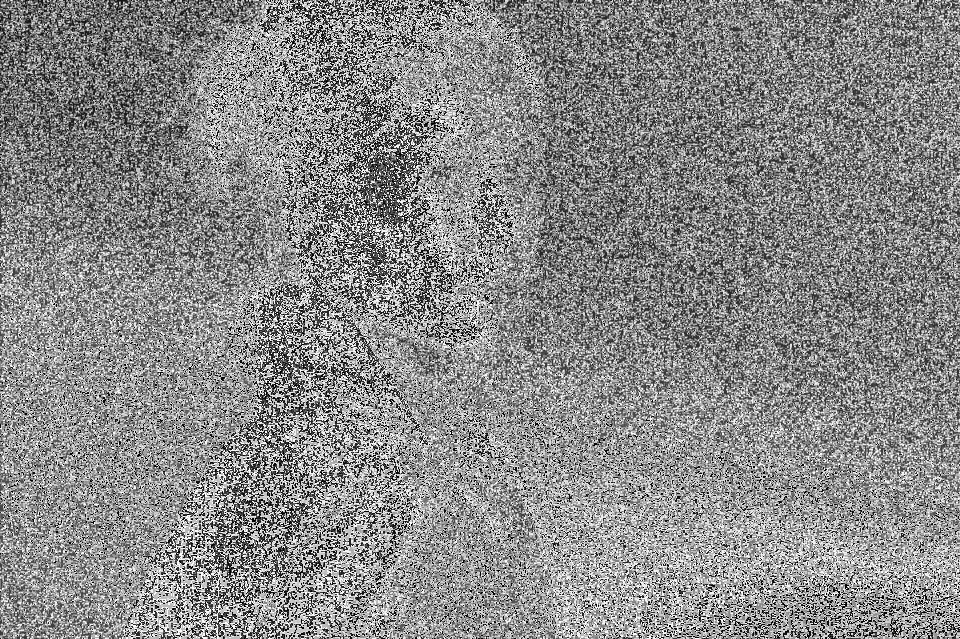

(639, 960)


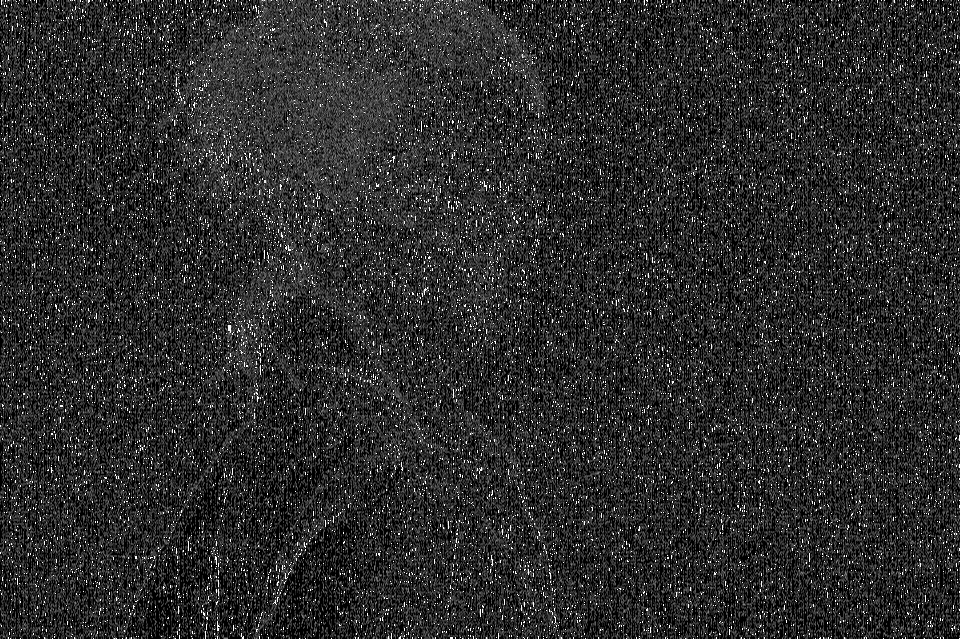

(639, 960)


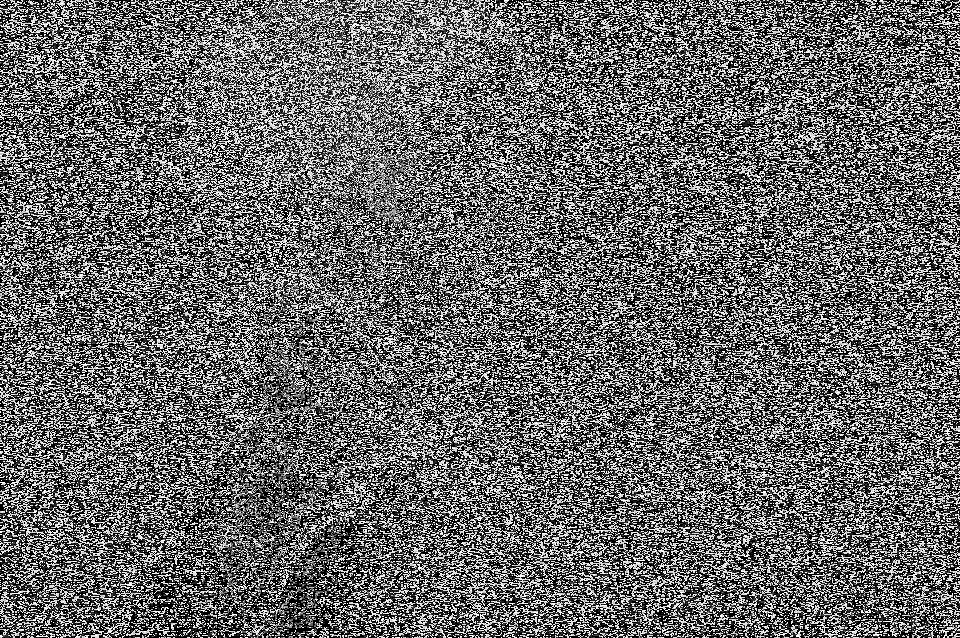

(638, 960)


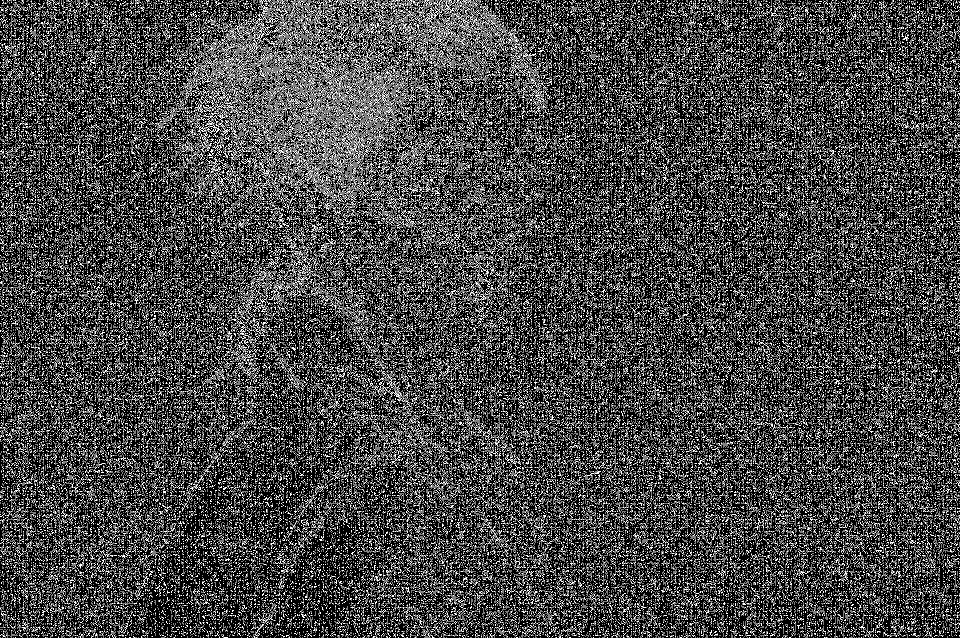

(638, 960)


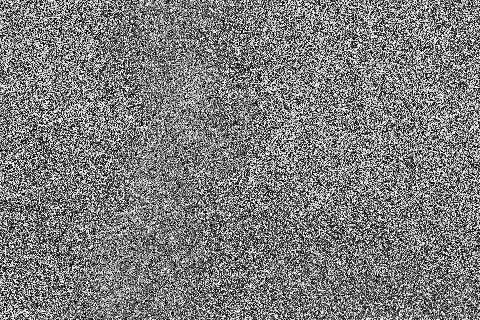

(320, 480)


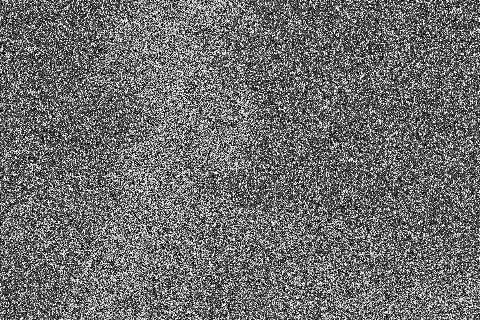

(320, 480)


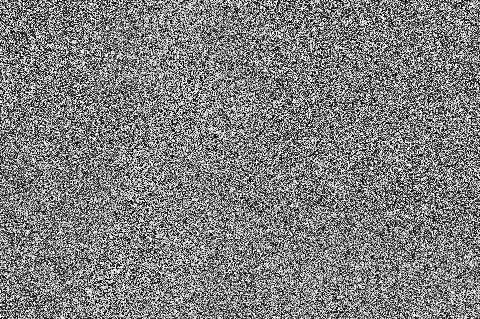

(319, 480)


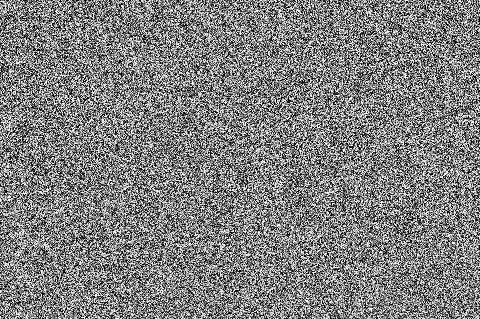

(319, 480)


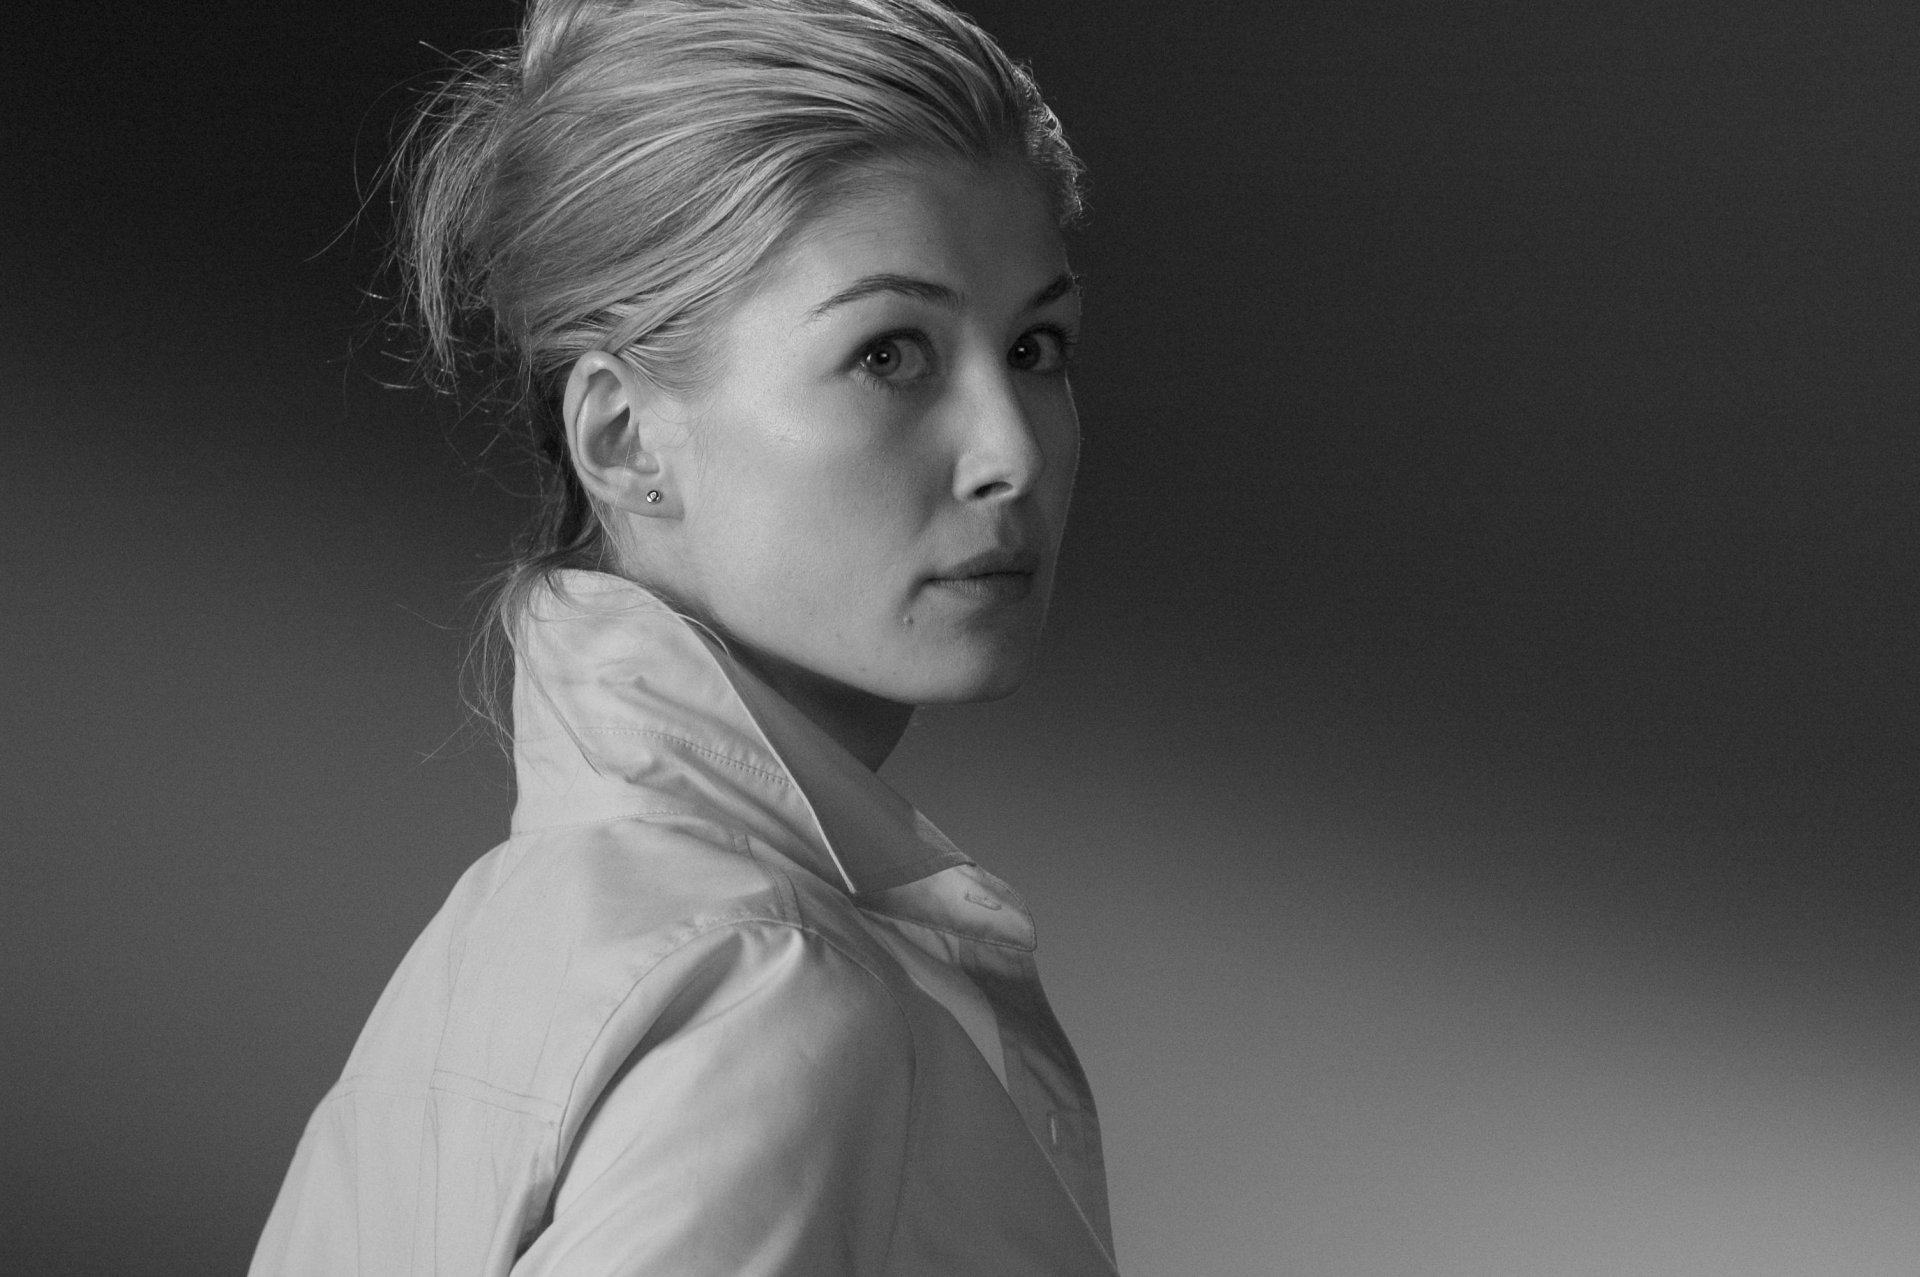

In [69]:
import cv2

def test_2d_dwt_image():

    img = cv2.imread('data/images/thumb.jpg', cv2.IMREAD_GRAYSCALE)
    ll, hl, lh, hh = dwt2d(img)
    
    display(HTML('<h2>Input Image</h2>'))
    display(Image.fromarray(img))
    print(img.shape)

    display(HTML('<h2>Output 2D DWT LVL 1</h2>'))
    display_images_in_grid(ll, hl, lh, hh)

    ll2, hl2, lh2, hh2 = dwt2d(ll)
    display(HTML('<h2>Output 2D DWT LVL 2</h2>'))
    display_images_in_grid(ll2, hl2, lh2, hh2)
    
    re_seq = test_2d_idwt_image((ll, hl, lh, hh), (ll2, hl2, lh2, hh2))
    display(HTML(f'<h2>Perfect Data Reconstruction... {np.array_equal(img,re_seq)}</h2>'))
    
def test_2d_idwt_image(lvl1_coeff, lvl2_coeff):
    
    ll, hl, lh, hh = lvl1_coeff
    ll2, hl2, lh2, hh2 = lvl2_coeff
    
    ll_i = idwt2d(ll2, hl2, lh2, hh2)
    img_i = idwt2d(ll_i, hl, lh, hh)
    
    display(HTML('<h2>Reconstructed Image</h2>'))
    display(Image.fromarray(img_i))
    return img_i
    
test_2d_dwt_image()

<br><h1>Selective Encryption on a file as proposed in <a href=https://ieeexplore.ieee.org/document/8692644>HanQiu[2021]</a></h1>

In [70]:
#Util Functions
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes


def bytes_to_bits(b):
    return ''.join([bin(byte)[2:].zfill(8) for byte in bytearray(b)])


def bits_to_bytes_v2(b, chunk_size=8):
    return bytes([int(''.join(b[i:i+chunk_size]), 2) for i in range(0, len(b), chunk_size)])

def sha256_with_key(key, data):
    combined = key + data
    sha256_obj = hashlib.sha256()
    sha256_obj.update(combined)
    return sha256_obj.hexdigest()


def sha512_with_key(key, data):
    combined = key + data
    sha512_obj = hashlib.sha512()
    sha512_obj.update(combined)
    return sha512_obj.hexdigest()

# def xor_with_sha_key(data, sha_hex):
#     sha_bytes = bytes.fromhex(sha_hex)
#     xor_result = bytes([b1 ^ b2 for b1, b2 in zip(data, sha_bytes)])
#     return xor_result

def xor_with_sha_key(data, sha_hex):
    sha_bytes = bytes.fromhex(sha_hex)
    sha_length = len(sha_bytes)
    extended_sha_bytes = sha_bytes * (len(data) // sha_length) + sha_bytes[:len(data) % sha_length]
    xor_result = bytes([b1 ^ b2 for b1, b2 in zip(data, extended_sha_bytes)])
    return xor_result


def recover_data_from_xor(xor_data, sha_hex):
    sha_bytes = bytes.fromhex(sha_hex)
    recovered_data = bytes([b ^ sha_bytes[i] for i, b in enumerate(xor_data)])
    return recovered_data


def aes_encrypt(data, key):
    iv = get_random_bytes(16)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    encrypted_data = cipher.encrypt(pad(data, AES.block_size))
    return iv + encrypted_data


def aes_decrypt(encrypted_data, key):
    iv = encrypted_data[:16]
    encrypted_data = encrypted_data[16:]
    cipher = AES.new(key, AES.MODE_CBC, iv)
    decrypted_data = unpad(cipher.decrypt(encrypted_data), AES.block_size)
    return decrypted_data



In [71]:
import os

def se_encrypt(file_path, buffer,sha_key_str, aes_key):    
    chunk_size = buffer * buffer
    sha_key = sha_key_str.encode()
    ll2_enc_key = aes_key
    d_private_fragment = []
    d_public_protected_fragment_1 = []
    d_public_protected_fragment_2 = []
        
    with open(file_path, 'rb') as file:
        while True:
            
            chunk = file.read(chunk_size)

            if not chunk:
                # print("Reached End of the file.\n")
                break
            
            if len(chunk) < chunk_size:
                chunk += b'\x00' * (chunk_size - len(chunk))
            
            byte_array = np.frombuffer(chunk, dtype=np.uint8)
            byte_array_2d = np.reshape(byte_array, (buffer, buffer))
            
            #Step 1, 2D DWT LVL 1
            ll, hl, lh, hh = dwt2d(byte_array_2d)
    
            #Step 2, 2D DWT LVL 2
            ll2, hl2, lh2, hh2 = dwt2d(ll)

            #Step 3, SHA-256 with key, on ll2, for PPF1
            SHA256_PPF1 = sha256_with_key(sha_key, ll2.tobytes())
            
            #Step 4, SHA-512 with key, on (lh2, hl2, hh2), for PPF2
            SHA512_PPF2 = sha512_with_key(sha_key, np.array([lh2,hl2,hh2]).tobytes())        
            
            #Step 5, PPF1 generation, XOR using generated SHA-256 from ll2
            PPF1_bytes = np.array([hl2, lh2, hh2]).tobytes()
            PPF1_XOR = xor_with_sha_key(PPF1_bytes, SHA256_PPF1)
            
            #Step 6, PPF2 generation, XOR using generated SHA-512 from (lh2, hl2, hh2)
            PPF2_bytes = np.array([hl, lh, hh]).tobytes()
            PPF2_XOR = xor_with_sha_key(PPF2_bytes, SHA512_PPF2)
                        
            
            #Step 7, Encrypt LL2 (AES 256)
            encrypted_ll2 = aes_encrypt(ll2.tobytes(), ll2_enc_key)

            #Step 7, Append to Data Sequence
            d_private_fragment.append(np.frombuffer(encrypted_ll2, dtype=np.uint8))
            d_public_protected_fragment_1.append(np.frombuffer(PPF1_XOR, dtype=np.uint8))
            d_public_protected_fragment_2.append(np.frombuffer(PPF2_XOR, dtype=np.uint8))
    
    np.save(f'{file_path[:file_path.rfind("/")]}/enc/{file_path.split("/")[-1]}_PF.npy', np.array(d_private_fragment))
    np.save(f'{file_path[:file_path.rfind("/")]}/enc/{file_path.split("/")[-1]}_PPF_1.npy', np.array(d_public_protected_fragment_1))
    np.save(f'{file_path[:file_path.rfind("/")]}/enc/{file_path.split("/")[-1]}_PPF_2.npy', np.array(d_public_protected_fragment_2))




In [72]:
def se_decrypt(file_PF, file_PPF_1, file_PPF_2, buffer, output_file_path, sha_key_str, aes_key):
    
    sha_key = sha_key_str.encode()
    ll2_enc_key = aes_key

    d_private_fragment = np.load(file_PF)
    d_public_protected_fragment_1 = np.load(file_PPF_1)
    d_public_protected_fragment_2 = np.load(file_PPF_2)

    
    with open(output_file_path, 'wb') as file:
        for i in range(len(d_private_fragment)):
            
            #Step 1, get the LL2 from encrypted private fragment
            ll2_dec = aes_decrypt(d_private_fragment[i].tobytes(), ll2_enc_key)
            ll2 = np.frombuffer(ll2_dec, dtype=np.uint8).reshape(int(buffer/4), int(buffer/4))

            #Step 2, Get PPF1
            sha256_ppf1 = sha256_with_key(sha_key, ll2.tobytes())
            ppf1_bytes = xor_with_sha_key(d_public_protected_fragment_1[i].tobytes(), sha256_ppf1)
            ppf1 = np.frombuffer(ppf1_bytes, dtype=np.uint8)
            hl2, lh2, hh2 = np.split(ppf1, 3)
            hl2 = hl2.reshape(int(buffer/4), int(buffer/4))
            lh2 = lh2.reshape(int(buffer/4), int(buffer/4))
            hh2 = hh2.reshape(int(buffer/4), int(buffer/4))
            
            #Step 3, Get PPF2
            sha512_ppf2 = sha512_with_key(sha_key, np.array([lh2,hl2,hh2]).tobytes())        
            ppf2_bytes = xor_with_sha_key(d_public_protected_fragment_2[i].tobytes(), sha512_ppf2)
            ppf2 = np.frombuffer(ppf2_bytes, dtype=np.uint8)
         
            hl, lh, hh = np.split(ppf2, 3)
            hl = hl.reshape(int(buffer/2), int(buffer/2))
            lh = lh.reshape(int(buffer/2), int(buffer/2))
            hh = hh.reshape(int(buffer/2), int(buffer/2))
            
            #Step 4, Get ll
            ll = idwt2d(ll2, hl2, lh2, hh2)
            
            #Step 5, Get original chunk
            byte_array_2d = idwt2d(ll, hl, lh, hh)
            chunk = byte_array_2d.reshape(-1)
            
            if i==len(d_private_fragment)-1:
                chunk = np.trim_zeros(chunk, 'b')
            
            file.write(chunk.tobytes())

<b>Example post quantum secure communication between ALice and Bob</b>

In [73]:
#Requires Pre knowledge for all parties 
buffer_size = 1024 # y of (y X y)
sha_key_str = 'Tuesday Evening'

In [74]:
from quantcrypt.kem import Kyber

kem = Kyber()

In [75]:
#ALice generates key pair
public_key, secret_key = kem.keygen()

In [76]:
#Bob generates cipher and shared secret using ALice's pk
cipher_text, shared_secret = kem.encaps(public_key)

#Bob encrypts the message using shared_secret
se_encrypt(file_path='data/files/landscape.png',
           sha_key_str=sha_key_str, 
           buffer=buffer_size,
           aes_key=shared_secret)

In [77]:
#ALice decrypts cipher she receives from Bob to extract shared secret
shared_secret_copy = kem.decaps(secret_key, cipher_text)

In [78]:
#ALice decrypts the message using shared_secret_copy
se_decrypt(file_PF= 'data/files/enc/landscape.png_PF.npy',
           file_PPF_1= 'data/files/enc/landscape.png_PPF_1.npy',
           file_PPF_2= 'data/files/enc/landscape.png_PPF_2.npy',
           buffer=buffer_size,
           output_file_path='data/files/dec/landscape.png',
           sha_key_str=sha_key_str, 
           aes_key=shared_secret_copy)